In [ ]:
### XGBoost implementation with cross-validation

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error

# Load data
start_time = time.time()
data = pd.read_csv('ind_output_2D.csv')

# Define features (X) and target (Y)
X = data.iloc[:, :11]           # Observed variables
X = X.drop('npz', axis=1)       
Y = data.iloc[:, -1]            # Response variable (keff)

# Split the data into training and testing sets (log transofrmation on Y)
X_train, X_test, Y_train_log, Y_test_log = train_test_split(X, np.log10(Y), test_size=0.2, random_state=45)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data into DMatrix (XGBoost optimized data structure)
dtrain = xgb.DMatrix(X_train, label=Y_train_log)
dtest = xgb.DMatrix(X_test, label=Y_test_log)

# Parameters tuning
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'eval_metric': 'rmse',
    'colsample_bytree': 0.863,
    'learing_rate': 0.066,
    'max_depth': 8,
    'subsample': 0.614,
    'reg_alpha': 0.324,
    'reg_lambda': 0.122,
    'min_sample_loss': 0.05
    #'tree_method': 'gpu_hist',    # Use GPU for training
    #'predictor': 'gpu_predictor'  # Use GPU for prediction
}

# Perform cross-validation using xgb.cv
cv_results = xgb.cv(
    dtrain = dtrain,
    params = params,
    nfold = 5,                      # number of cross-validation folds
    num_boost_round = 1000,         # maximum boosting rounds
    early_stopping_rounds = 50,     # stop if no improvement after 50 rounds
    metrics = 'rmse',
    as_pandas = True,               # return results as Pandas DataFrame
    seed = 36,
    verbose_eval = True
)

# Get the optimal number of boosting rounds based on cross-validation results
best_num_boost_rounds = cv_results['test-rmse-mean'].idxmin()
print(f'Optimal number of boosting rounds: {best_num_boost_rounds}')

# Train final model using optimal number of rounds
xgb_regressor = xgb.train(
    params = params,
    dtrain = dtrain,
    num_boost_round = best_num_boost_rounds
)

end_time = time.time()

# Save the trained model to a json file
model_filename = 'model_xgbCV.json.json'
xgb_regressor.save_model(model_filename)
print(f'Model saved to {model_filename}')

# Predict on test and train data
Y_pred_log_test = xgb_regressor.predict(dtest)
Y_pred_log_train = xgb_regressor.predict(dtrain)

# Return predictions to the original scale and retrieve regression results
Y_pred_test = 10**(Y_pred_log_test)
Y_pred_train = 10**(Y_pred_log_train)
Y_train = 10**(Y_train_log)
Y_test = 10**(Y_test_log)

# Define custom evaluation function: mean relative squared error (mrse)
def mean_relative_squared_error(Y_true, Y_pred):
    return np.mean(((Y_true - Y_pred) / Y_true) ** 2)

# Evaluate the model
r2_xgb = r2_score(Y_test, Y_pred_test)
mse_xgb = mean_squared_error(Y_test, Y_pred_test)
mae_xgb = mean_absolute_error(Y_test, Y_pred_test)
mlsr_xgb = mean_squared_log_error(Y_test, Y_pred_test)
mrse_xgb = mean_relative_squared_error(Y_test, Y_pred_test)
running_time = end_time - start_time

# Create a dataframe with the evaluation metrics.
eval_metrics_xgbCV = {
    'Eval_metrics': ['R2 Score', 
                     'Mean squared error',
                     'Mean absolute error', 
                     'Mean squared log error', 
                     'Mean relative squared error',
                     'Training time (s)'],
    'XGBoost CV': [r2_xgb, 
                mse_xgb, 
                mae_xgb, 
                mlsr_xgb, 
                mrse_xgb,
                running_time]
}

df_metrics_xgbCV = pd.DataFrame(eval_metrics_xgbCV)
df_metrics_xgbCV.to_csv('metrics_xgbCV.csv', index=False)
print(df_metrics_xgbCV)

/home/cpicighelli/ccd/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:48:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "learing_rate", "min_sample_loss" } are not used.

  warnings.warn(smsg, UserWarning)
/home/cpicighelli/ccd/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:48:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "learing_rate", "min_sample_loss" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.73912+0.00009	test-rmse:0.73913+0.00040
[1]	train-rmse:0.51824+0.00007	test-rmse:0.51826+0.00028
[2]	train-rmse:0.36387+0.00005	test-rmse:0.36388+0.00020
[3]	train-rmse:0.25614+0.00003	test-rmse:0.25617+0.00016
[4]	train-rmse:0.18123+0.00003	test-rmse:0.18127+0.00013
[5]	train-rmse:0.12945+0.00002	test-rmse:0.12950+0.00013
[6]	train-rmse:0.09410+0.00001	test-rmse:0.09416+0.00010
[7]	train-rmse:0.07049+0.00002	test-rmse:0.07057+0.00009
[8]	train-rmse:0.05521+0.00001	test-rmse:0.05532+0.00009
[9]	train-rmse:0.04580+0.00002	test-rmse:0.04594+0.00008
[10]	train-rmse:0.04032+0.00002	test-rmse:0.04048+0.00006
[11]	train-rmse:0.03729+0.00003	test-rmse:0.03747+0.00005
[12]	train-rmse:0.03564+0.00004	test-rmse:0.03584+0.00005
[13]	train-rmse:0.03475+0.00003	test-rmse:0.03497+0.00005
[14]	train-rmse:0.03426+0.00004	test-rmse:0.03448+0.00005
[15]	train-rmse:0.03396+0.00005	test-rmse:0.03421+0.00006
[16]	train-rmse:0.03377+0.00005	test-rmse:0.03402+0.00006
[17]	train-rmse:0.03364+

/home/cpicighelli/ccd/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:49:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "learing_rate", "min_sample_loss" } are not used.

  warnings.warn(smsg, UserWarning)


Model saved to model_xgbCV.json.json
                  Eval_metrics  XGBoost CV
0                     R2 Score    0.998021
1           Mean squared error    0.339625
2          Mean absolute error    0.316907
3       Mean squared log error    0.002081
4  Mean relative squared error    0.006010
5            Training time (s)   65.702192


In [ ]:
### Load the saved XGBoost model

loaded_model = xgb.Booster()
loaded_model.load_model('xgb_regressor_CV.json')
#print(f'Model loaded from {'xgb_regressor.json'}')

# Predict with the loaded model
Y_pred_log_test_loaded = loaded_model.predict(dtest)
Y_pred_log_train_loaded = loaded_model.predict(dtrain)

Y_pred_test_loaded = 10**(Y_pred_log_test_loaded)
Y_pred_train_loaded = 10**(Y_pred_log_train_loaded)

# Ensure predictions from the saved model match the original predictions
assert np.allclose(Y_pred_test, Y_pred_test_loaded), "Predictions from the saved model do not match the original predictions."

<Figure size 2500x400 with 0 Axes>

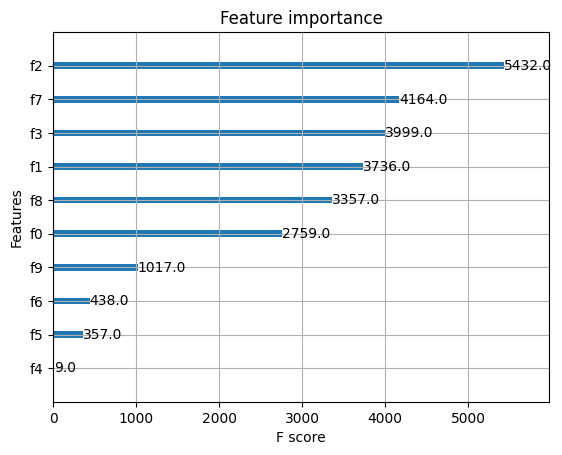

Feature 0: PPHA
Feature 1: VOLALE
Feature 2: ZNCC
Feature 3: GAMMA
Feature 4: spanning
Feature 5: npy
Feature 6: npx
Feature 7: Plen
Feature 8: S
Feature 9: P


In [ ]:
### XGBoost plots
# Plot fearures importance

plt.figure(figsize=(25, 4))
xgb.plot_importance(xgb_regressor, max_num_features=10)
plt.title('Feature importance plot')
plt.show()
feature_names = X.columns
for i, feature in enumerate(feature_names):
    print(f"Feature {i}: {feature}")

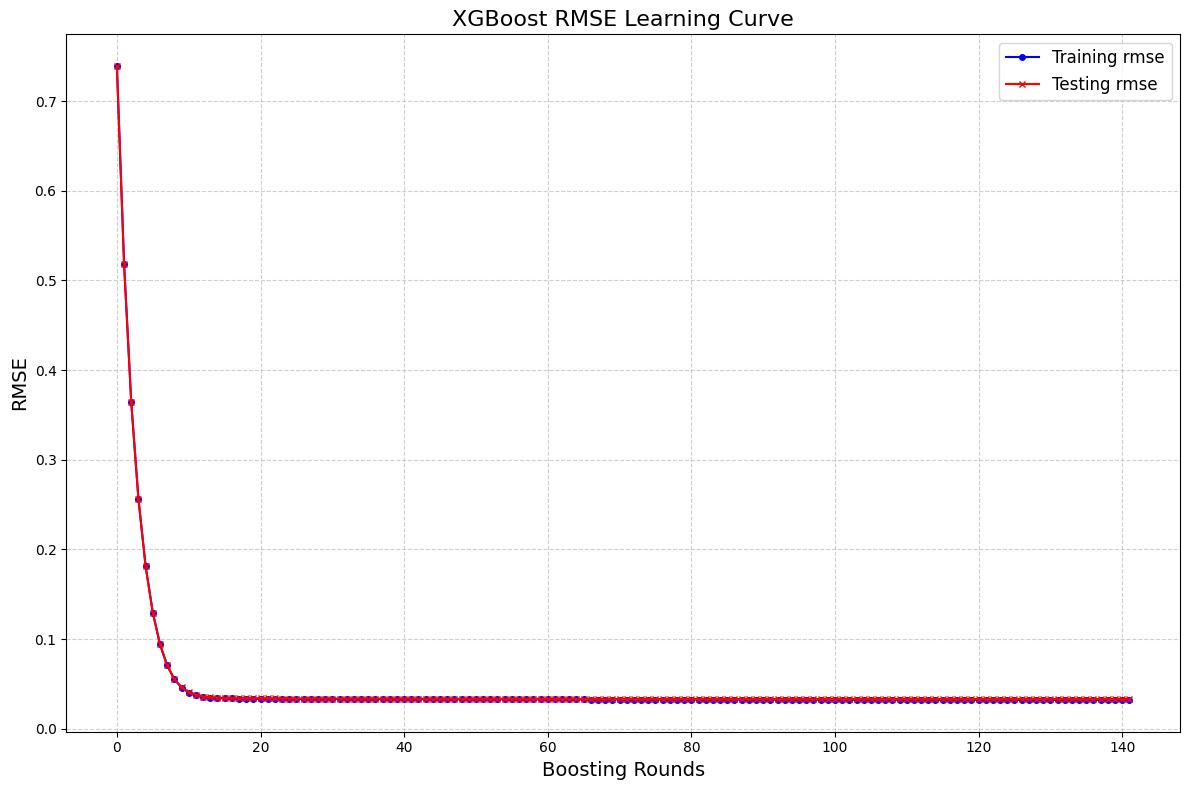

In [ ]:
### XGBoost plots
'''
RMSE learning curves plot: Tracking the training progress of the model by plotting the learning 
curves, which show how the RMSE changes as more rounds of boosting are performed.
'''

epochs = len(cv_results['train-rmse-mean'])
x_axis = range(epochs)
plt.figure(figsize=(12, 8))
plt.plot(x_axis, cv_results['train-rmse-mean'], label='Training rmse', color='b', marker='o', markersize=4)
plt.plot(x_axis, cv_results['test-rmse-mean'], label='Testing rmse', color='r', marker='x', markersize=4)
plt.title('XGBoost RMSE Learning Curve', fontsize=16)
plt.xlabel('Boosting Rounds', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.grid(visible=True, which='both', linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

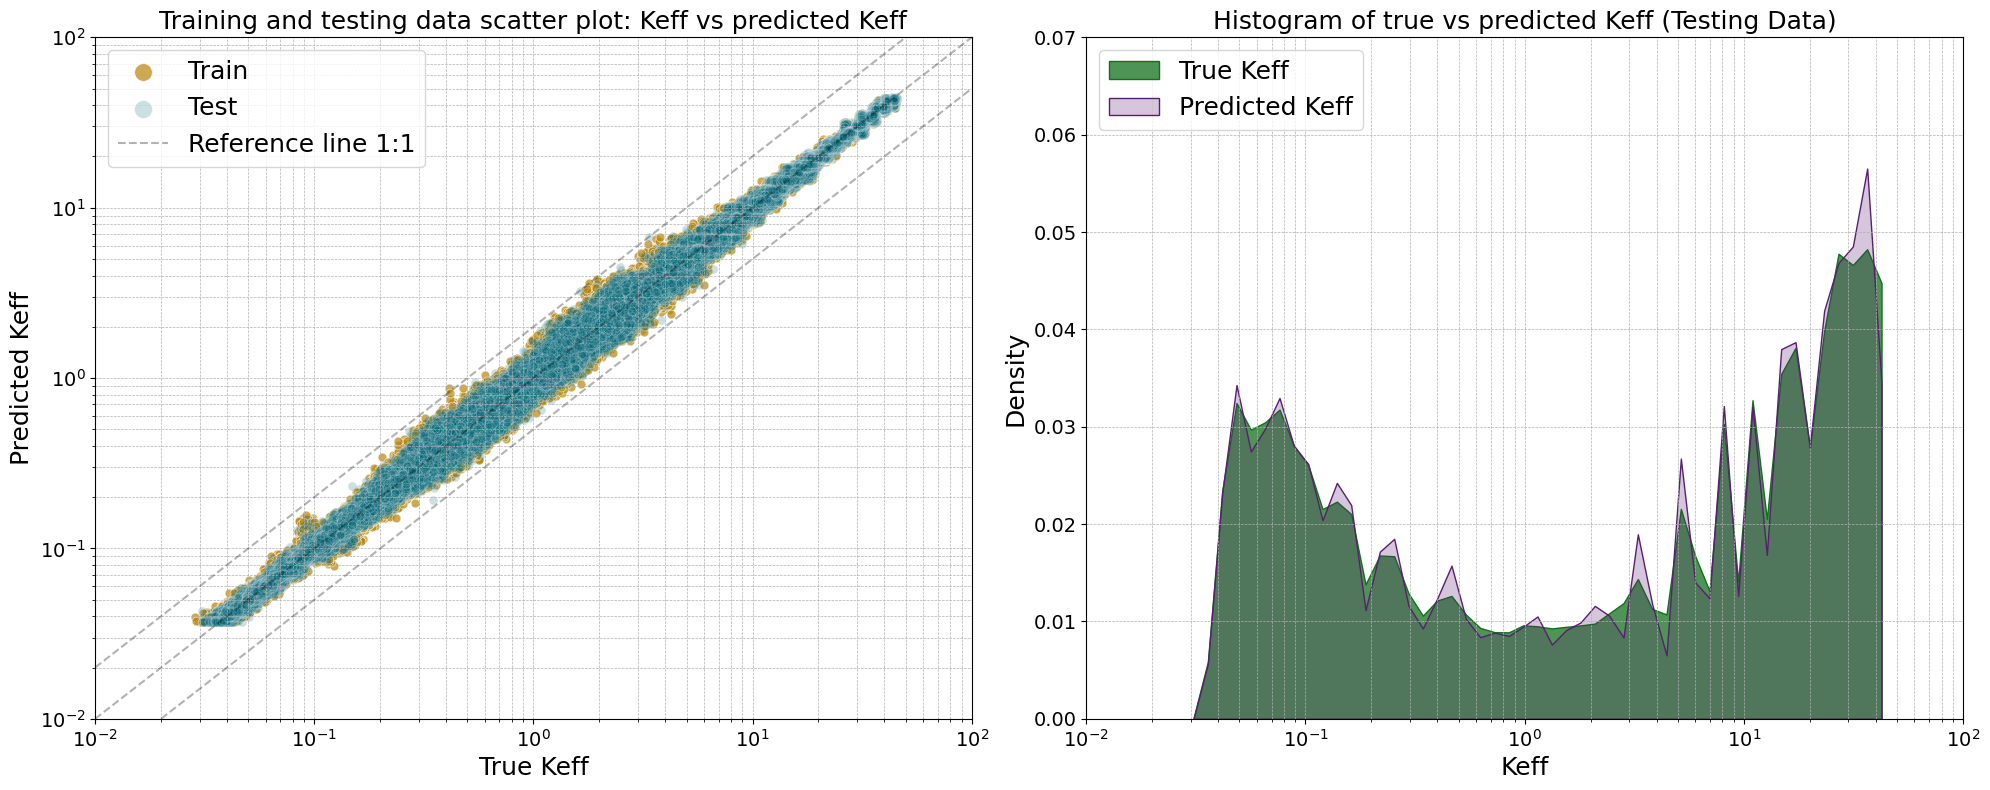

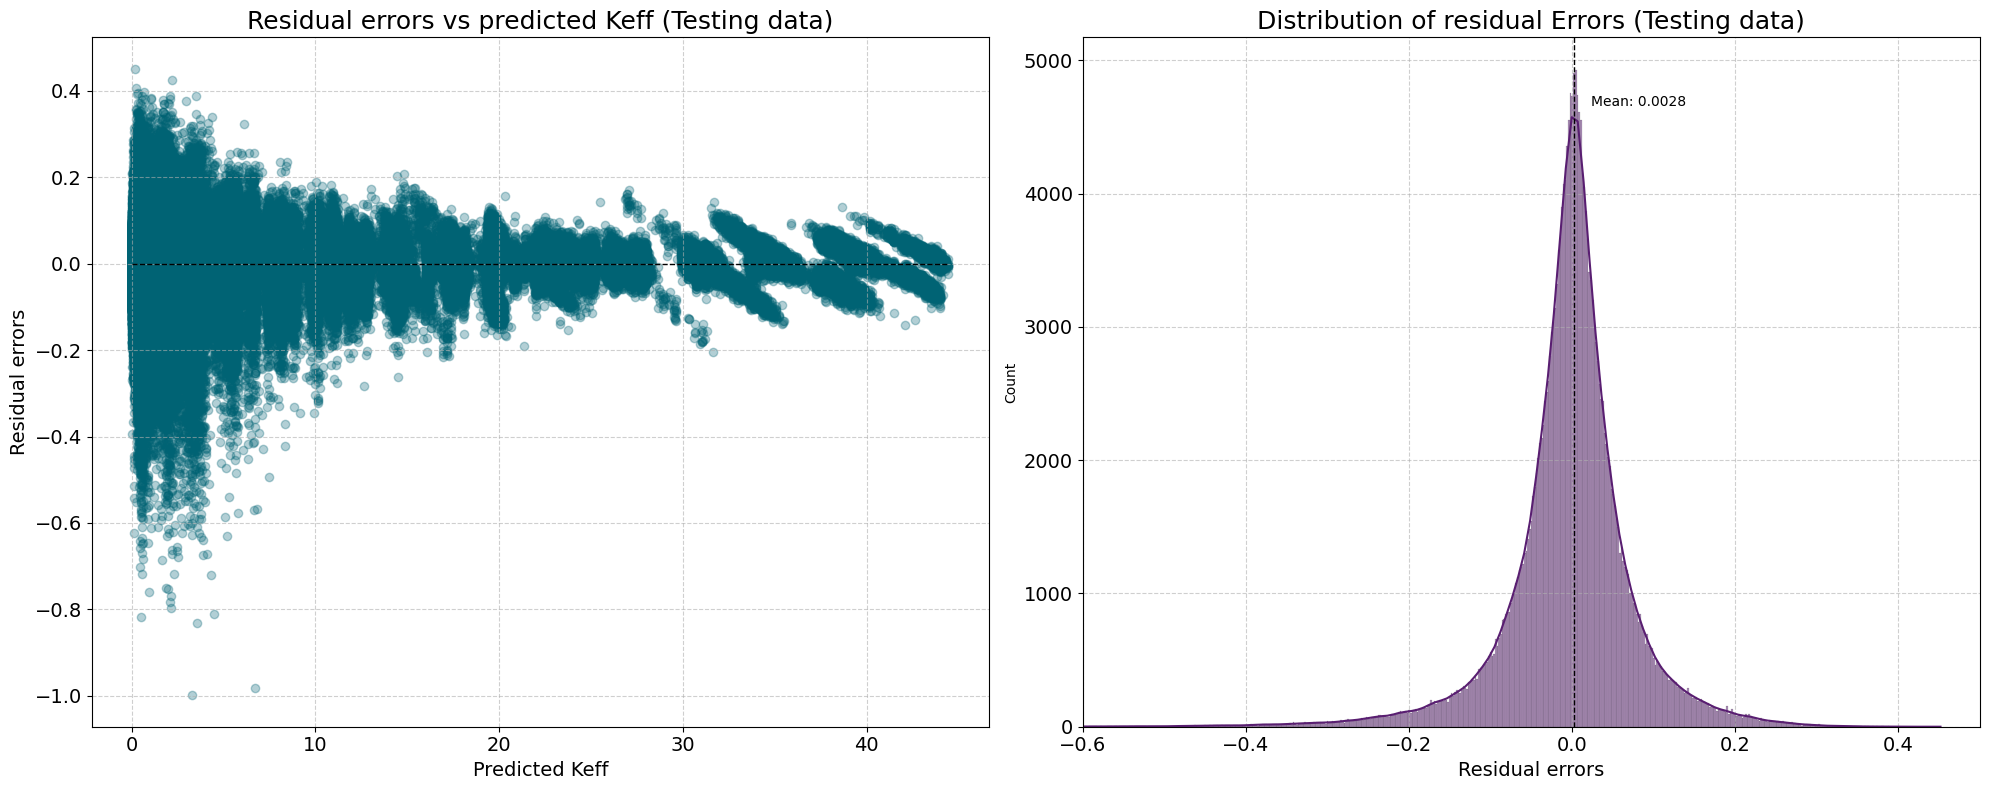

In [ ]:
### XGBoost plots
# Filter data

data_plot_train = pd.DataFrame(Y_train)
data_plot_train['Y_pred_train'] = Y_pred_train
data_plot_train_rel = ((data_plot_train['keff']-data_plot_train['Y_pred_train'])/data_plot_train['keff'])

data_plot_test = pd.DataFrame(Y_test)
data_plot_test['Y_pred_test'] = Y_pred_test
data_plot_test_rel = ((data_plot_test['keff']-data_plot_test['Y_pred_test'])/data_plot_test['keff'])

# Scatter plot for Train data
palette = sns.color_palette('dark')
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x='keff', 
    y='Y_pred_train',
    data=data_plot_train,
    label='Train', 
    color=palette[8], 
    s=40,  
    alpha=0.70)

sns.scatterplot(
    x='keff', 
    y='Y_pred_test', 
    data=data_plot_test,
    label='Test', 
    color=palette[9], 
    s=40,  
    alpha=0.20)

plt.loglog([1E-2, 1E2], [1E-2, 1E2], c='k', alpha=0.3, linestyle='--', label='Reference line 1:1')
plt.loglog([1E-2, 0.5E2], [2E-2, 1E2], c='k', alpha=0.3, linestyle='--')
plt.loglog([2E-2, 1E2], [1E-2, 0.5E2], c='k', alpha=0.3, linestyle='--')

plt.legend(loc='upper left', fontsize=18, markerscale=2)
plt.xlim([1E-2, 1E2])
plt.ylim([1E-2, 1E2])
plt.xlabel('True Keff', fontsize=18)
plt.ylabel('Predicted Keff', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Training and testing data scatter plot: Keff vs predicted Keff', fontsize=18)

# Histogram for Testing data
plt.subplot(1, 2, 2)

logMin, logMax = np.log10(data_plot_train['keff'].min()), np.log10(data_plot_train['keff'].max())
newBins = np.logspace(logMin, logMax, 50)

sns.histplot(
    data_plot_test['keff'], 
    bins=newBins, 
    kde=False, 
    color=palette[2],
    stat="probability", 
    element='poly', 
    label='True Keff', 
    alpha=0.75)

sns.histplot(
    data_plot_test['Y_pred_test'], 
    bins=newBins, 
    kde=False, 
    color=palette[4], 
    stat="probability", 
    element='poly', 
    label='Predicted Keff', 
    alpha=0.25)

plt.legend(loc='upper left', fontsize=18)
plt.xlim([1E-2, 1E2])
plt.ylim([0, 0.07])
plt.xscale('log')
plt.ylabel("Density", fontsize=18)
plt.xlabel('Keff', fontsize=18)
plt.title('Histogram of true vs predicted Keff (Testing Data)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Residuals error plot
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
residuals = (Y_test - Y_pred_test) / Y_test
plt.scatter(Y_pred_test, residuals, alpha=0.3, color=palette[9])
plt.hlines(y=0, xmin=Y_pred_test.min(), xmax=Y_pred_test.max(), colors='k', linestyles='--', linewidth=1)
plt.xlabel('Predicted Keff', fontsize=14)
plt.ylabel('Residual errors', fontsize=14)
plt.title('Residual errors vs predicted Keff (Testing data)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Error distribution plot
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color=palette[4], alpha=0.5)
plt.xlabel('Residual errors', fontsize=14)
plt.xlim(-0.6, 0.5)
plt.title('Distribution of residual Errors (Testing data)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

mean_residual = abs(residuals.mean())
plt.axvline(mean_residual, color='k', linestyle='--', linewidth=1)
plt.text(mean_residual + 0.02, plt.ylim()[1] * 0.9, f'Mean: {mean_residual:.4f}', color='k')
plt.tight_layout()
plt.show()

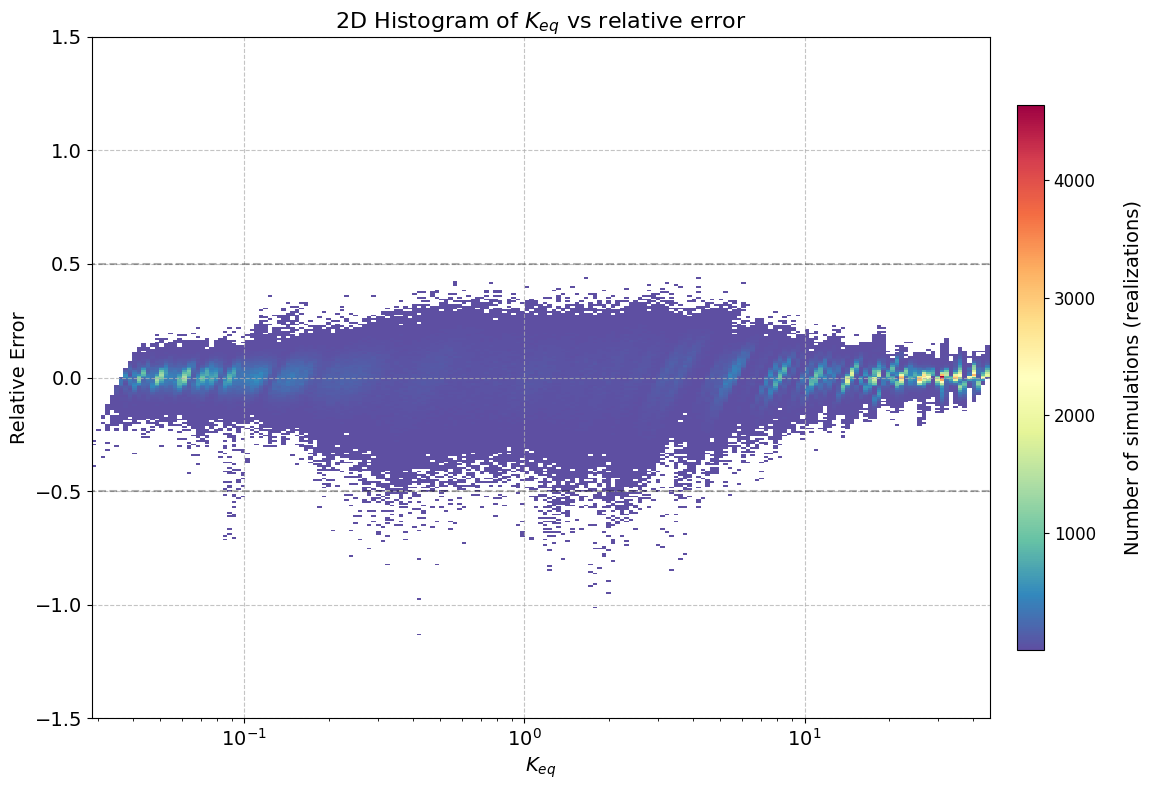

In [67]:
# 2D Histogram (Keff vs. Relative error)
plt.figure(figsize=(12, 8))
x = data_plot_train['keff']
y = data_plot_train_rel
LogMin, LogMax = np.log10(data_plot_train['keff'].min()), np.log10(data_plot_train['keff'].max())
newBins = np.logspace(LogMin, LogMax, 200)
hist2d = plt.hist2d(x, y, bins=[newBins, 200], cmap=plt.cm.Spectral_r, cmin=1)
cbar = plt.colorbar(pad=0.025, shrink=0.8)#.ax.set_yscale('log')
cbar.set_label(label='Number of simulations (realizations)', fontsize=14, labelpad=20)
cbar.ax.tick_params(labelsize=12)
plt.plot([1E-3, 1E2], [0.5, 0.5], c='k', alpha=0.3, linestyle='--')
plt.plot([1E-3, 1E2], [-0.5, -0.5], c='k', alpha=0.3, linestyle='--')
plt.xscale('log')
plt.xlabel(r'$K_{eq}$',  fontsize=14)
plt.ylim([-1.5, 1.5])
plt.ylabel('Relative Error', fontsize=14)
plt.title('2D Histogram of '+r'$K_{eq}$'+' vs relative error', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.75)
plt.tight_layout()
plt.show()

In [ ]:
### XGBoost implementation with RandomizedSearchCV for faster hyperparametr tuning
'''
Unlike GridSearchCV, which tries all possible combiationn of hyperparameters,
RandomizedSearchCV samples a fixed number of hyperparameters combinations from
the specified space. This is useful when you have a large hyprparameteres space,
as it saves time by exploring only a subset of all possible combinations.
'''

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from scipy.stats import uniform, randint

start_time_RS = time.time()

data = pd.read_csv('ind_output_2D.csv')

X = data.iloc[:, :11]
X = X.drop('npz', axis=1)
Y = data.iloc[:, -1]

X_train_xgb_rs, X_test_xgb_rs, Y_train_log_xgb_rs, Y_test_log_xgb_rs = train_test_split(X, np.log(Y), test_size=0.2, random_state=45)

scaler = StandardScaler()
X_train_xgb_rs = scaler.fit_transform(X_train_xgb_rs)
X_test_xgb_rs = scaler.transform(X_test_xgb_rs)

# Define the XGBoost regressor 
xgb_regressor = xgb.XGBRegressor() # (tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False)   # Use GPU for training

# Define the space of hyperparameters
param_distributions = {
    'colsample_bytree': uniform(0.3, 0.7),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 1000),
    'subsample': uniform(0.4, 0.6),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Define scoring functions
scorers = {
    'r2': make_scorer(r2_score),
    'neg_mse': make_scorer(mean_squared_error, greater_is_better=False)
}

# RandomizedSearchCV with cross-validation to optimize hyperparameter tuning
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_distributions,
    scoring=scorers,
    refit='r2',         # Refit the model using R² after searching
    cv=4,               # 4-fold cross-validation
    n_iter=25,          # Number of random combinations to try
    verbose=1,
    random_state=42,
    n_jobs=-1           # -1 to use all processors avalaible
)

# Fit the RSCV to find the best parameters
random_search_xgb.fit(X_train_xgb_rs, Y_train_log_xgb_rs)

# Get the best parameters
best_params = random_search_xgb.best_params_
print(f'Best hyperparameters: {best_params}')

params_filename = 'best_params_xgbRS.json'
with open(params_filename, 'w') as params_file:
    json.dump(best_params, params_file)
print(f'Best hyperparameters saved to: {params_filename}')

# Instantiate and train the XGBoost regressor with the best hyperparameters 
xgb_regressor = xgb.XGBRegressor(**best_params, eval_metrics='rmse', early_stopping_rounds=500) #, tree_method='gpu_hist', predictor='gpu_predictor',)  ## Use GPU for training
xgb_model = xgb_regressor.fit(X_train_xgb_rs, Y_train_log_xgb_rs, verbose=True, eval_set = [(X_train_xgb_rs, Y_train_log_xgb_rs), (X_test_xgb_rs, Y_test_log_xgb_rs)])

end_time_RS = time.time()

# Save the trained XGBoost model to a file
model_filename = 'model_xgbRS.json'
xgb_model.save_model(model_filename)
print(f'Model saved to {model_filename}')

# Predict on test data
Y_pred_log_test_xgb_rs = xgb_model.predict(X_test_xgb_rs)
Y_pred_log_train_xgb_rs = xgb_model.predict(X_train_xgb_rs)

# Return predictions to the original scale
Y_pred_test_xgb_rs = np.exp(Y_pred_log_test_xgb_rs)
Y_pred_train_xgb_rs = np.exp(Y_pred_log_train_xgb_rs)
Y_train_xgb_rs = np.exp(Y_train_log_xgb_rs)
Y_test_xgb_rs = np.exp(Y_test_log_xgb_rs)

# Evaluate the model
# Define custom evaluation function: Mean Relative Squared Error (MRSE)
def mean_relative_squared_error(Y_true, Y_pred):
    return np.mean(((Y_true - Y_pred) / Y_true) ** 2)

r2_xgb_rs = r2_score(Y_test_xgb_rs, Y_pred_test_xgb_rs)
mse_xgb_rs = mean_squared_error(Y_test_xgb_rs, Y_pred_test_xgb_rs)
mae_xgb_rs = mean_absolute_error(Y_test_xgb_rs, Y_pred_test_xgb_rs)
mslr_xgb_rs = mean_squared_log_error(Y_test_xgb_rs, Y_pred_test_xgb_rs)
mrse_xgb_rs = mean_relative_squared_error(Y_test_xgb_rs, Y_pred_test_xgb_rs)
running_time_xgbRS = end_time_RS - start_time_RS

# Create a dataframe with the evaluation metrics.
eval_metrics_xgbRS = {
    'Eval_metrics': ['R2 Score', 
                     'Mean Squared Error',
                     'Mean Absolute Error',  
                     'Mean Squared Log Error',
                     'Mean Relative Squeared Error', 
                     'Training time (s)'],

    'XGBoost RS': [r2_xgb_rs, 
                   mse_xgb_rs,
                   mae_xgb_rs,  
                   mslr_xgb_rs, 
                   mrse_xgb_rs,
                   running_time_xgbRS]
}

df_metrics_xgbRS = pd.DataFrame(eval_metrics_xgbRS)
df_metrics_xgbRS.to_csv('metrics_xgbRS.csv', index=False)
print(df_metrics_xgbRS)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best hyperparameters: {'colsample_bytree': 0.8625704538293801, 'learning_rate': 0.06597101766581075, 'max_depth': 8, 'n_estimators': 430, 'reg_alpha': 0.32434502100527396, 'reg_lambda': 0.12208795470067335, 'subsample': 0.613778702846185}
Best hyperparameters saved to: best_params_xgbRS.json
[0]	validation_0-rmse:2.26851	validation_1-rmse:2.26682
[1]	validation_0-rmse:2.11916	validation_1-rmse:2.11759


/home/cpicighelli/ccd/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:11:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-rmse:1.97968	validation_1-rmse:1.97821
[3]	validation_0-rmse:1.84940	validation_1-rmse:1.84803
[4]	validation_0-rmse:1.72774	validation_1-rmse:1.72646
[5]	validation_0-rmse:1.61412	validation_1-rmse:1.61292
[6]	validation_0-rmse:1.50802	validation_1-rmse:1.50691
[7]	validation_0-rmse:1.40893	validation_1-rmse:1.40790
[8]	validation_0-rmse:1.31640	validation_1-rmse:1.31543
[9]	validation_0-rmse:1.22997	validation_1-rmse:1.22907
[10]	validation_0-rmse:1.14928	validation_1-rmse:1.14843
[11]	validation_0-rmse:1.07394	validation_1-rmse:1.07316
[12]	validation_0-rmse:1.00370	validation_1-rmse:1.00298
[13]	validation_0-rmse:0.93814	validation_1-rmse:0.93746
[14]	validation_0-rmse:0.87682	validation_1-rmse:0.87620
[15]	validation_0-rmse:0.81956	validation_1-rmse:0.81898
[16]	validation_0-rmse:0.76611	validation_1-rmse:0.76557
[17]	validation_0-rmse:0.71623	validation_1-rmse:0.71573
[18]	validation_0-rmse:0.66970	validation_1-rmse:0.66924
[19]	validation_0-rmse:0.62625	validati

In [ ]:
df_metrics_xgbCV['XGBoost RS'] = df_metrics_xgbRS['XGBoost RS'].values
df_metrics_xgbCV.to_csv('metrics_xgb.csv', index=False)

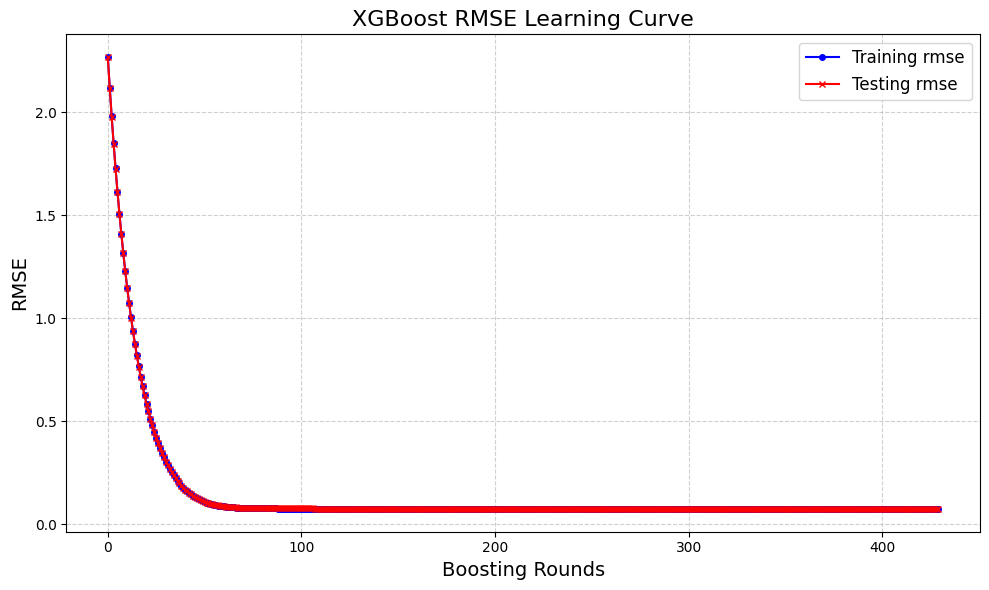

In [ ]:
### RMSE Learning curves plot
'''
RMSE learning curves plot: Tracking the training progress of the model by plotting the learning 
curves, which show how the RMSE changes as more rounds of boosting are performed.
'''

# Extract evaluation results from the trained model
results = xgb_regressor.evals_result()

def plot_learning_curves(results, metric, title):
    train_metric = results['validation_0'][metric]
    test_metric = results['validation_1'][metric]

    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label=f'Training {metric}', color='b', marker='o', markersize=4)
    plt.plot(test_metric, label=f'Testing {metric}', color='r', marker='x', markersize=4)
    plt.xlabel('Boosting Rounds', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(visible=True, which='both', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
plot_learning_curves(results, metric='rmse', title='XGBoost RMSE Learning Curve')



In [3]:
import json
path = '/home/chris/projects/ml/indicators/best_params.json'
with open(path, 'r') as file:
    data = json.load(file)
print(json.dumps(data, indent=4))

{
    "colsample_bytree": 0.8625704538293801,
    "learning_rate": 0.06597101766581075,
    "max_depth": 8,
    "n_estimators": 430,
    "reg_alpha": 0.32434502100527396,
    "reg_lambda": 0.12208795470067335,
    "subsample": 0.613778702846185
}


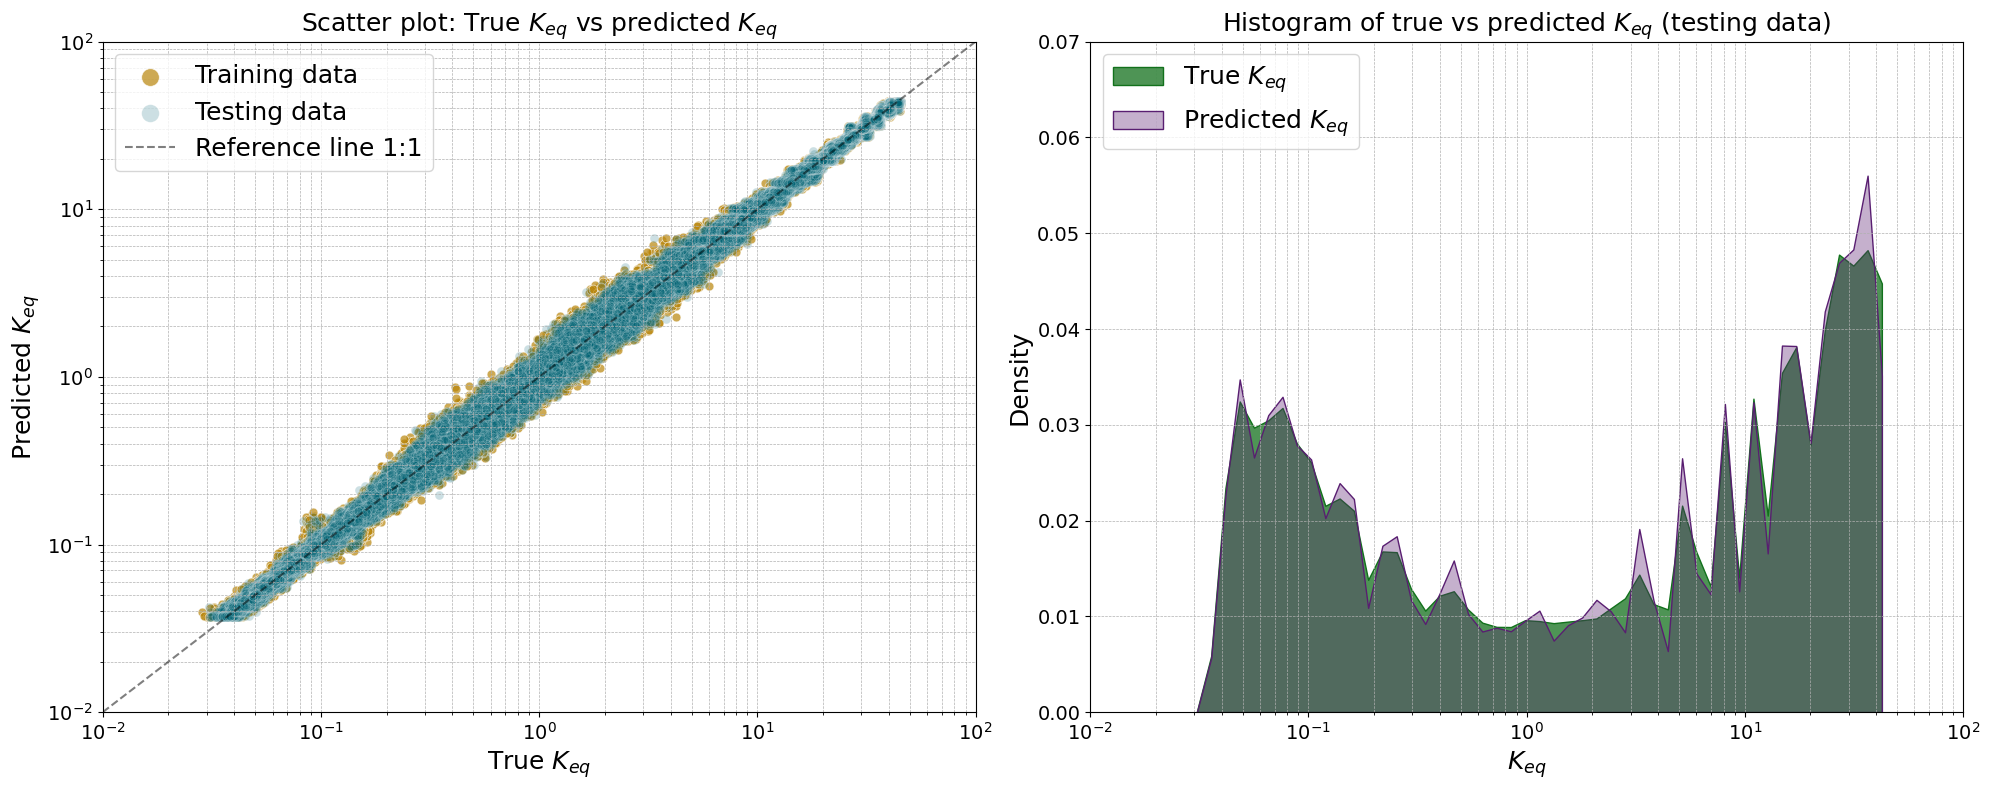

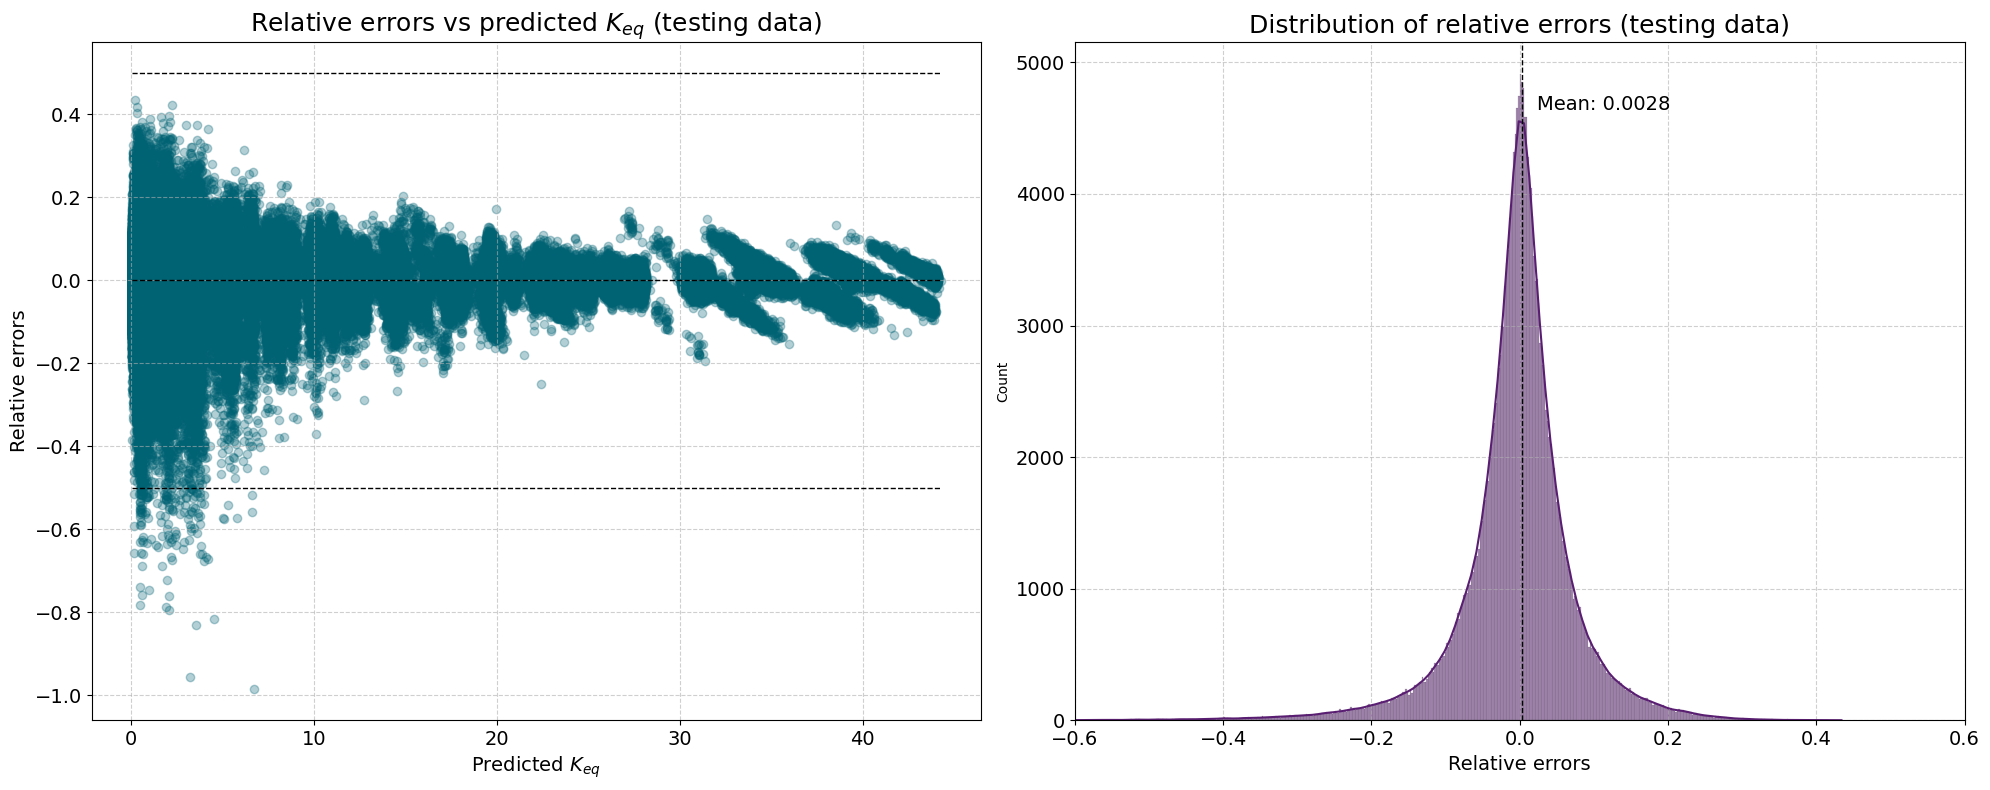

In [38]:
### XGBoost plots
# Filter data
data_plot_train_xgb_rs = pd.DataFrame(Y_train_xgb_rs)
data_plot_train_xgb_rs ['Y_pred_train_xgb_rs'] = Y_pred_train_xgb_rs
data_plot_train_rel_xgb_rs  = ((data_plot_train_xgb_rs ['keff']-data_plot_train_xgb_rs ['Y_pred_train_xgb_rs'])/data_plot_train_xgb_rs ['keff'])

data_plot_test_xgb_rs  = pd.DataFrame(Y_test_xgb_rs)
data_plot_test_xgb_rs ['Y_pred_test_xgb_rs'] = Y_pred_test_xgb_rs
data_plot_test_rel_xgb_rs = ((data_plot_test_xgb_rs ['keff']-data_plot_test_xgb_rs ['Y_pred_test_xgb_rs'])/data_plot_test_xgb_rs ['keff'])

residuals_std = Y_pred_test_xgb_rs - Y_test_xgb_rs
std_dev = np.std(residuals_std)


# Scatter plot for Train data
palette = sns.color_palette('dark')
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x='keff', 
    y='Y_pred_train_xgb_rs', 
    data=data_plot_train_xgb_rs,
    label='Training data', 
    color=palette[8], 
    s=40,  
    alpha=0.70)

sns.scatterplot(
    x='keff', 
    y='Y_pred_test_xgb_rs', 
    data=data_plot_test_xgb_rs,
    label='Testing data', 
    color=palette[9], 
    s=40,  
    alpha=0.20)

plt.loglog([1E-2, 1E2], [1E-2, 1E2], c='k', alpha=0.50, linestyle='--', label='Reference line 1:1')
#plt.loglog([1E-2, 0.5E2], [2E-2, 1E2], c='k', alpha=0.3, linestyle='--')
#plt.loglog([2E-2, 1E2], [1E-2, 0.5E2], c='k', alpha=0.3, linestyle='--')

plt.legend(loc='upper left', fontsize=18, markerscale=2)
plt.xlim([1E-2, 1E2])
plt.ylim([1E-2, 1E2])
plt.xlabel('True '+r'$K_{eq}$', fontsize=18)
plt.ylabel('Predicted '+r'$K_{eq}$', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Scatter plot: True '+r'$K_{eq}$'+' vs predicted '+r'$K_{eq}$', fontsize=18)

# Histogram for Testing data
plt.subplot(1, 2, 2)

logMin, logMax = np.log10(data_plot_train_xgb_rs['keff'].min()), np.log10(data_plot_train_xgb_rs['keff'].max())
newBins = np.logspace(logMin, logMax, 50)

sns.histplot(
    data_plot_test_xgb_rs['keff'], 
    bins=newBins, 
    kde=False, 
    color=palette[2],
    stat="probability", 
    element='poly', 
    label='True '+r'$K_{eq}$', 
    alpha=0.75)
sns.histplot(
    data_plot_test_xgb_rs['Y_pred_test_xgb_rs'], 
    bins=newBins, 
    kde=False, 
    color=palette[4], 
    stat="probability", 
    element='poly', 
    label='Predicted '+r'$K_{eq}$', 
    alpha=0.35)

plt.legend(loc='upper left', fontsize=18)
plt.xlim([1E-2, 1E2])
plt.ylim([0, 0.07])
plt.xscale('log')
plt.ylabel("Density", fontsize=18)
plt.xlabel(r'$K_{eq}$', fontsize=18)
plt.title('Histogram of true vs predicted '+r'$K_{eq}$'+' (testing data)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Relative error plot
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
relative_xgb_rs = (Y_test_xgb_rs - Y_pred_test_xgb_rs) / Y_test_xgb_rs
plt.scatter(Y_pred_test_xgb_rs, relative_xgb_rs, alpha=0.3, color=palette[9])
plt.hlines(y=0, xmin=Y_pred_test_xgb_rs.min(), xmax=Y_pred_test_xgb_rs.max(), colors='k', linestyles='--', linewidth=1)
plt.hlines(y=0.5, xmin=Y_pred_test_xgb_rs.min(), xmax=Y_pred_test_xgb_rs.max(), colors='k', linestyles='--', linewidth=1)
plt.hlines(y=-0.5, xmin=Y_pred_test_xgb_rs.min(), xmax=Y_pred_test_xgb_rs.max(), colors='k', linestyles='--', linewidth=1)
plt.xlabel('Predicted '+r'$K_{eq}$', fontsize=14)
plt.ylabel('Relative errors', fontsize=14)
plt.title('Relative errors vs predicted '+r'$K_{eq}$'+' (testing data)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Error distribution plot
plt.subplot(1, 2, 2)
sns.histplot(relative_xgb_rs, kde=True, color=palette[4], alpha=0.5)
plt.xlabel('Relative errors', fontsize=14)
plt.xlim(-0.6, 0.6)
plt.title('Distribution of relative errors (testing data)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
mean_residual_xgb_rs = abs(relative_xgb_rs.mean())
plt.axvline(mean_residual_xgb_rs, color='k', linestyle='--', linewidth=1)
plt.text(mean_residual_xgb_rs + 0.02, plt.ylim()[1] * 0.9, f'Mean: {mean_residual_xgb_rs:.4f}', color='k', fontsize=14)
plt.tight_layout()
plt.show()

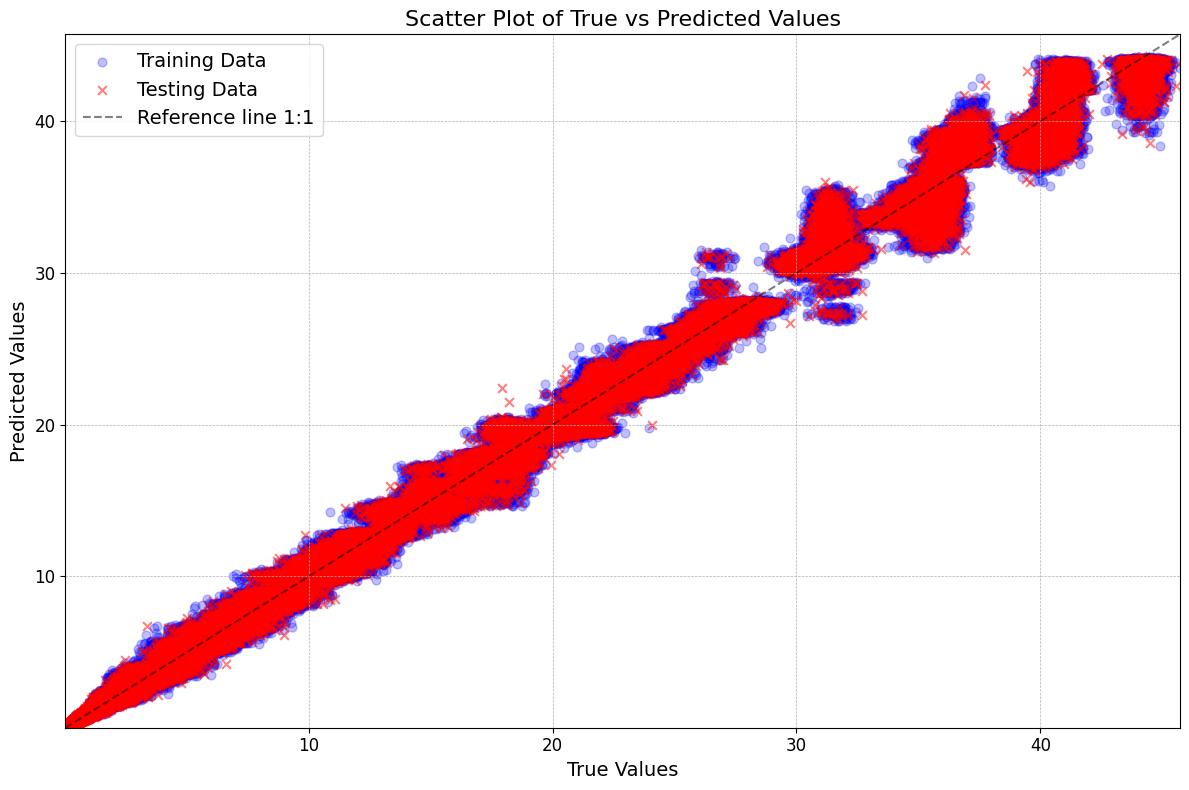

In [125]:
# Assuming Y_train, Y_pred_train, Y_test, and Y_pred_test are your true and predicted values for training and testing data

# Scatter plot
plt.figure(figsize=(12, 8))

# Training data
plt.scatter(Y_train_xgb_rs, Y_pred_train_xgb_rs, label='Training Data', color='blue', s=40, alpha=0.25, marker='o')

# Testing data
plt.scatter(Y_test_xgb_rs, Y_pred_test_xgb_rs, label='Testing Data', color='red', s=40, alpha=0.5, marker='x')

# Reference line (1:1)
plt.plot([min(Y_train_xgb_rs.min(), Y_test_xgb_rs.min()), max(Y_train_xgb_rs.max(), Y_test_xgb_rs.max())], 
         [min(Y_train_xgb_rs.min(), Y_test_xgb_rs.min()), max(Y_train_xgb_rs.max(), Y_test_xgb_rs.max())], 
         c='k', alpha=0.5, linestyle='--', label='Reference line 1:1')

plt.legend(loc='upper left', fontsize=14)
plt.xlim([min(Y_train_xgb_rs.min(), Y_test_xgb_rs.min()), max(Y_train_xgb_rs.max(), Y_test_xgb_rs.max())])
plt.ylim([min(Y_train_xgb_rs.min(), Y_test_xgb_rs.min()), max(Y_train_xgb_rs.max(), Y_test_xgb_rs.max())])
plt.xlabel('True Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Scatter Plot of True vs Predicted Values', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

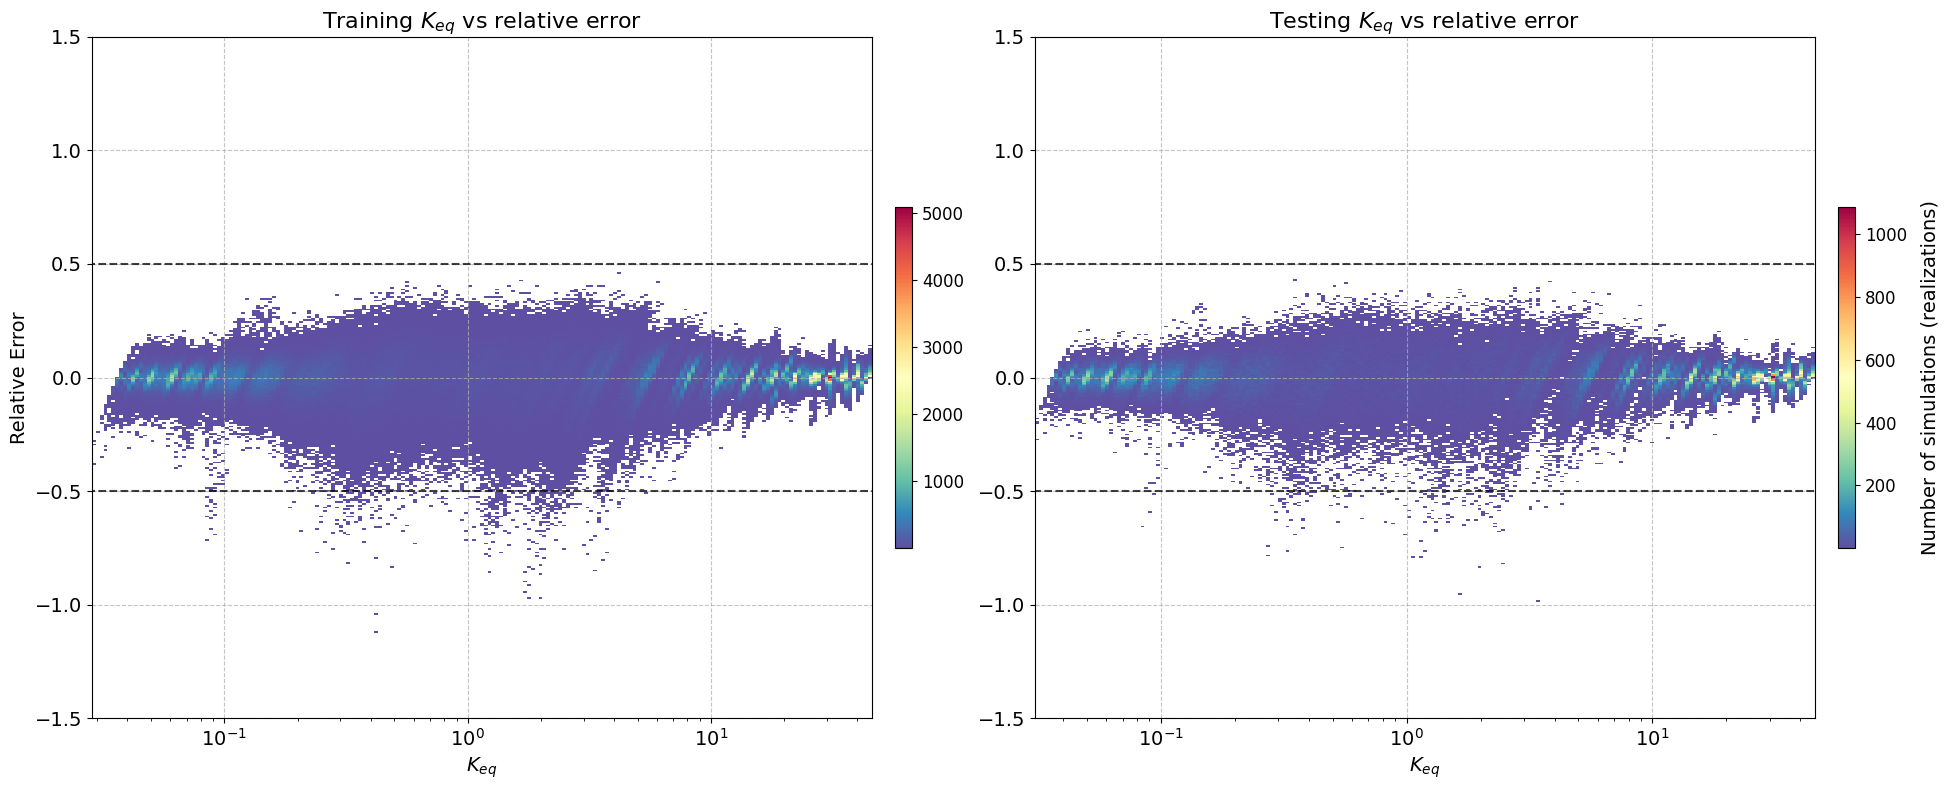

In [103]:
# 2D HISTOGRAM 
# 2D Histogram (Keff vs. Relative error) training data
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
x = data_plot_train_xgb_rs['keff']
y = data_plot_train_rel_xgb_rs
LogMin, LogMax = np.log10(data_plot_train_xgb_rs['keff'].min()), np.log10(data_plot_train_xgb_rs['keff'].max())
newBins = np.logspace(LogMin, LogMax, 200)
hist2d = plt.hist2d(x, y, bins=[newBins, 200], cmap=plt.cm.Spectral_r, cmin=1)
cbar = plt.colorbar(pad=0.025, shrink=0.5)#.ax.set_yscale('log')
#cbar.set_label(label='Number of simulations (realizations)', fontsize=14, labelpad=10)
cbar.ax.tick_params(labelsize=12)
plt.plot([1E-3, 1E2], [0.5, 0.5], c='k', alpha=0.75, linestyle='--')
plt.plot([1E-3, 1E2], [-0.5, -0.5], c='k', alpha=0.75, linestyle='--')
plt.xscale('log')
plt.xlabel(r'$K_{eq}$',  fontsize=14)
plt.ylim([-1.5, 1.5])
plt.ylabel('Relative Error', fontsize=14)
plt.title('Training '+r'$K_{eq}$'+' vs relative error', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.75)
plt.tight_layout()


# 2D Histogram (Keff vs. Relative error) testing data 
plt.subplot(1, 2, 2)
x = data_plot_test_xgb_rs['keff']
y = data_plot_test_rel_xgb_rs
LogMin, LogMax = np.log10(data_plot_test_xgb_rs['keff'].min()), np.log10(data_plot_test_xgb_rs['keff'].max())
newBins = np.logspace(LogMin, LogMax, 200)
hist2d = plt.hist2d(x, y, bins=[newBins, 200], cmap=plt.cm.Spectral_r, cmin=1)
cbar = plt.colorbar(pad=0.025, shrink=0.5)#.ax.set_yscale('log')
cbar.set_label(label='Number of simulations (realizations)', fontsize=14, labelpad=10)
cbar.ax.tick_params(labelsize=12)
plt.plot([1E-3, 1E2], [0.5, 0.5], c='k', alpha=0.75, linestyle='--')
plt.plot([1E-3, 1E2], [-0.5, -0.5], c='k', alpha=0.75, linestyle='--')
plt.xscale('log')
plt.xlabel(r'$K_{eq}$',  fontsize=14)
plt.ylim([-1.5, 1.5])
#plt.ylabel('Relative Error', fontsize=14)
plt.title('Testing '+r'$K_{eq}$'+' vs relative error', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.75)
plt.tight_layout()
plt.show()

In [111]:
error_data1 = data_plot_train_rel_xgb_rs[data_plot_train_rel_xgb_rs <= -0.5]
error_data2 = data_plot_train_rel_xgb_rs[data_plot_train_rel_xgb_rs >= 0.5]

error_training = ((len(error_data1)+len(error_data2))/len(data_plot_train_rel_xgb_rs))*100
print('El error en las predicciones de los datos de entrenamiento es de: ', error_training)

error_data3 = data_plot_test_rel_xgb_rs[data_plot_test_rel_xgb_rs <= -0.5]
error_data4 = data_plot_test_rel_xgb_rs[data_plot_test_rel_xgb_rs >= 0.5]

error_testing = ((len(error_data3)+len(error_data4))/len(data_plot_test_rel_xgb_rs))*100
print('El error en las predicciones de los datos de validaición es de: ', error_testing)

print(len(error_data1)+len(error_data2))
print(len(error_data3)+len(error_data4))
print(len(data_plot_train_rel_xgb_rs))
print(len(data_plot_test_rel_xgb_rs))

El error en las predicciones de los datos de entrenamiento es de:  0.056423611111111105
El error en las predicciones de los datos de validaición es de:  0.07291666666666667
520
168
921600
230400


In [ ]:
error_data3 = data_plot_test_rel_xgb_rs[data_plot_test_rel_xgb_rs <= -0.5]
error_data4 = data_plot_test_rel_xgb_rs[data_plot_test_rel_xgb_rs >= 0.5]

print(error_data1)
print(error_data2)

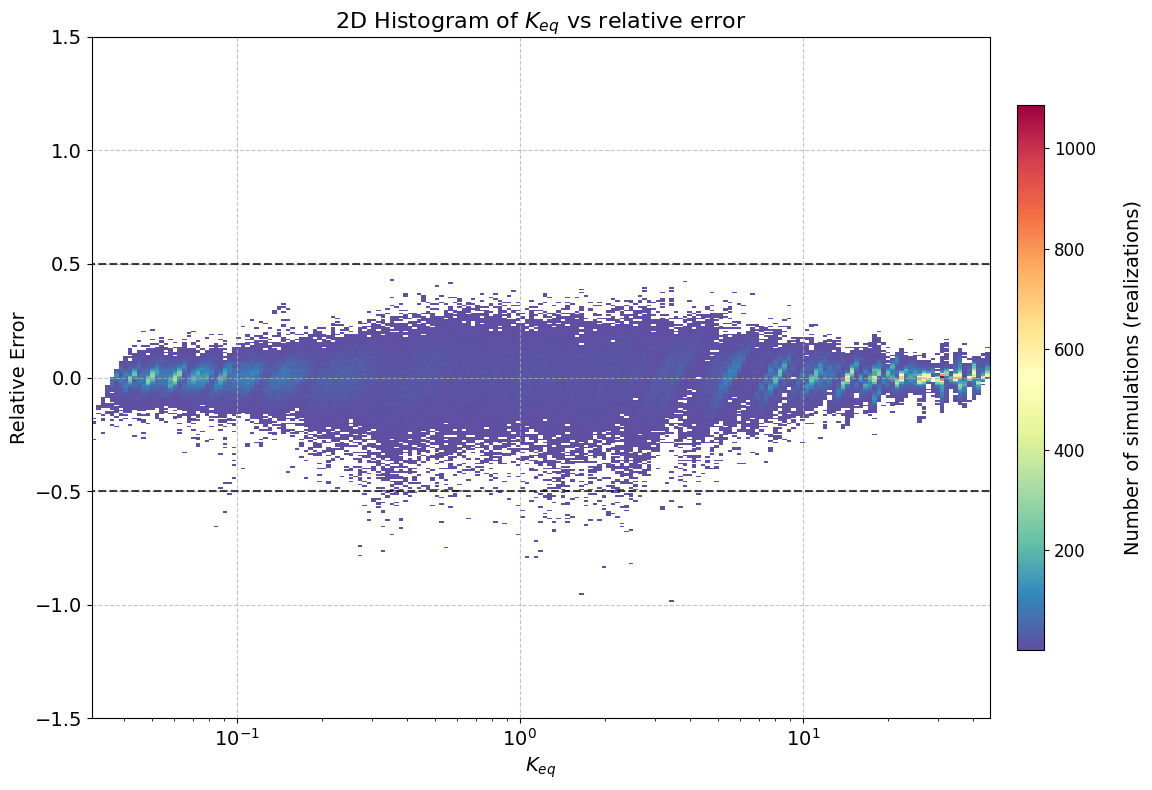

In [93]:
# 2D Histogram (Keff vs. Relative error) testing data 
plt.figure(figsize=(12, 8))
x = data_plot_test_xgb_rs['keff']
y = data_plot_test_rel_xgb_rs
LogMin, LogMax = np.log10(data_plot_test_xgb_rs['keff'].min()), np.log10(data_plot_test_xgb_rs['keff'].max())
newBins = np.logspace(LogMin, LogMax, 200)
hist2d = plt.hist2d(x, y, bins=[newBins, 200], cmap=plt.cm.Spectral_r, cmin=1)
cbar = plt.colorbar(pad=0.025, shrink=0.8)#.ax.set_yscale('log')
cbar.set_label(label='Number of simulations (realizations)', fontsize=14, labelpad=20)
cbar.ax.tick_params(labelsize=12)
plt.plot([1E-3, 1E2], [0.5, 0.5], c='k', alpha=0.75, linestyle='--')
plt.plot([1E-3, 1E2], [-0.5, -0.5], c='k', alpha=0.75, linestyle='--')
plt.xscale('log')
plt.xlabel(r'$K_{eq}$',  fontsize=14)
plt.ylim([-1.5, 1.5])
plt.ylabel('Relative Error', fontsize=14)
plt.title('2D Histogram of '+r'$K_{eq}$'+' vs relative error', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.75)
plt.tight_layout()
plt.show()

In [94]:
error_data1 = data_plot_test_rel_xgb_rs[data_plot_test_rel_xgb_rs <= -0.5]
error_data2 = data_plot_test_rel_xgb_rs[data_plot_test_rel_xgb_rs >= 0.5]

print(error_data1)
print(error_data2)

294574    -0.514833
1109766   -0.670715
1100317   -0.501272
680760    -0.501111
679460    -0.548901
             ...   
300922    -0.526616
313038    -0.514900
974441    -0.564115
294954    -0.506557
1085354   -0.591078
Length: 168, dtype: float64
Series([], dtype: float64)


In [40]:
sns.color_palette("dark")

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

In [ ]:
data = pd.read_csv('ind_output_2D.csv')

               PPHA        VOLALE          ZNCC         GAMMA      spanning  \
count  1.152000e+06  1.152000e+06  1.152000e+06  1.152000e+06  1.152000e+06   
mean   6.000019e-01  5.636524e-01  5.700391e+03  5.154390e-01  5.747908e-01   
std    1.213954e-01  4.404157e-01  4.079994e+03  4.393901e-01  4.943749e-01   
min    4.000015e-01  2.069465e-03  5.140000e+02  3.777925e-04  0.000000e+00   
25%    5.000010e-01  2.814871e-02  2.263000e+03  5.131702e-03  0.000000e+00   
50%    6.000004e-01  8.588773e-01  4.567000e+03  7.379961e-01  1.000000e+00   
75%    7.000027e-01  9.751172e-01  8.512000e+03  9.508545e-01  1.000000e+00   
max    8.000031e-01  9.970198e-01  1.822000e+04  9.940485e-01  1.000000e+00   

             npz           npy           npx          Plen             S  ...  \
count  1152000.0  1.152000e+06  1.152000e+06  1.152000e+06  1.152000e+06  ...   
mean         0.0  5.864340e-01  5.863030e-01  2.365909e+01  8.015560e+00  ...   
std          0.0  4.936575e-01  4.936945e-01 

In [ ]:
import pandas as pd
from tabulate import tabulate

metrics = pd.read_csv('metrics_xgbCV.csv')
xgbCV_GPU = pd.read_csv('metrics_xgbCV_GPU.csv')
xgbRS = pd.read_csv('metrics_xgbRS.csv')
xgbRS_GPU = pd.read_csv('metrics_xgbRS_GPU.csv')

metrics['XGBoost CV GPU'] = xgbCV_GPU['XGBoost CV'].values
metrics['XGBoost RS'] = xgbRS['XGBoost RS']
metrics['XGBoost RS GPU'] = xgbRS_GPU['XGBoost RS']

metrics = metrics.round(5)
metrics.to_csv('metrics_xgb.csv', index=False)
print(tabulate(metrics, headers='keys', tablefmt='pretty', showindex=False))

+-----------------------------+------------+----------------+------------+----------------+
|        Eval_metrics         | XGBoost CV | XGBoost CV GPU | XGBoost RS | XGBoost RS GPU |
+-----------------------------+------------+----------------+------------+----------------+
|          R2 Score           |  0.99802   |    0.99802     |  0.99806   |    0.99807     |
|     Mean squared error      |  0.33963   |    0.34061     |  0.33246   |    0.33164     |
|     Mean absolute error     |  0.31691   |    0.31891     |   0.3135   |    0.31265     |
|   Mean squared log error    |  0.00208   |    0.00212     |  0.00206   |    0.00206     |
| Mean relative squared error |  0.00601   |     0.0061     |  0.00595   |    0.00594     |
|      Training time (s)      |  77.24334  |    21.74814    | 1341.15314 |   515.57171    |
+-----------------------------+------------+----------------+------------+----------------+


                   Eval_metrics           Model    Value
1            Mean squared error      XGBoost CV   0.3396
2           Mean absolute error      XGBoost CV   0.3169
3        Mean squared log error      XGBoost CV   0.0021
4   Mean relative squared error      XGBoost CV   0.0060
6            Mean squared error  XGBoost CV GPU   0.3406
7           Mean absolute error  XGBoost CV GPU   0.3189
8        Mean squared log error  XGBoost CV GPU   0.0021
9   Mean relative squared error  XGBoost CV GPU   0.0061
11           Mean squared error      XGBoost RS   0.3325
12          Mean absolute error      XGBoost RS   0.3135
13       Mean squared log error      XGBoost RS   0.0021
14  Mean relative squared error      XGBoost RS   0.0060
16           Mean squared error  XGBoost RS GPU   0.3316
17          Mean absolute error  XGBoost RS GPU   0.3126
18       Mean squared log error  XGBoost RS GPU   0.0021
19  Mean relative squared error  XGBoost RS GPU   0.0059
21           Mean squared error

<Axes: xlabel='Model', ylabel='Value'>

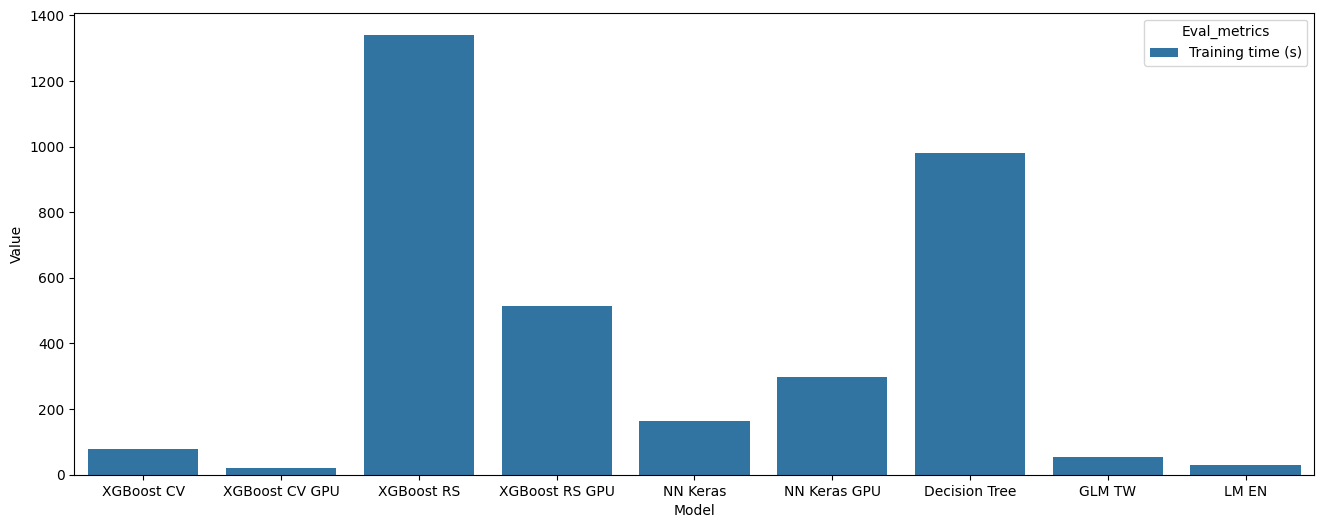

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Load data
metrics = pd.read_csv('metrics_xgb.csv')

metrics = metrics.round(4)
metrics1 = metrics[metrics['Eval_metrics'] != 'Training time (s)']
metrics2 = metrics[metrics['Eval_metrics'] == 'Training time (s)']

metrics1m = metrics1.melt(id_vars=['Eval_metrics'], var_name='Model', value_name='Value')
metrics2m = metrics2.melt(id_vars=['Eval_metrics'], var_name='Model', value_name='Value')

r2_data = metrics1m[metrics1m['Eval_metrics'] == 'R2 Score']
data = metrics1m[metrics1m['Eval_metrics'] != 'R2 Score']
print(data)

fig, ax1 = plt.subplots(figsize=(16, 6))
sns.barplot(x='Model', y='Value', hue='Eval_metrics', data=metrics2m)

                   Eval_metrics           Model    Value
1            Mean squared error      XGBoost CV   0.3396
2           Mean absolute error      XGBoost CV   0.3169
3        Mean squared log error      XGBoost CV   0.0021
4   Mean relative squared error      XGBoost CV   0.0060
6            Mean squared error  XGBoost CV GPU   0.3406
7           Mean absolute error  XGBoost CV GPU   0.3189
8        Mean squared log error  XGBoost CV GPU   0.0021
9   Mean relative squared error  XGBoost CV GPU   0.0061
11           Mean squared error      XGBoost RS   0.3325
12          Mean absolute error      XGBoost RS   0.3135
13       Mean squared log error      XGBoost RS   0.0021
14  Mean relative squared error      XGBoost RS   0.0060
16           Mean squared error  XGBoost RS GPU   0.3316
17          Mean absolute error  XGBoost RS GPU   0.3126
18       Mean squared log error  XGBoost RS GPU   0.0021
19  Mean relative squared error  XGBoost RS GPU   0.0059
21           Mean squared error

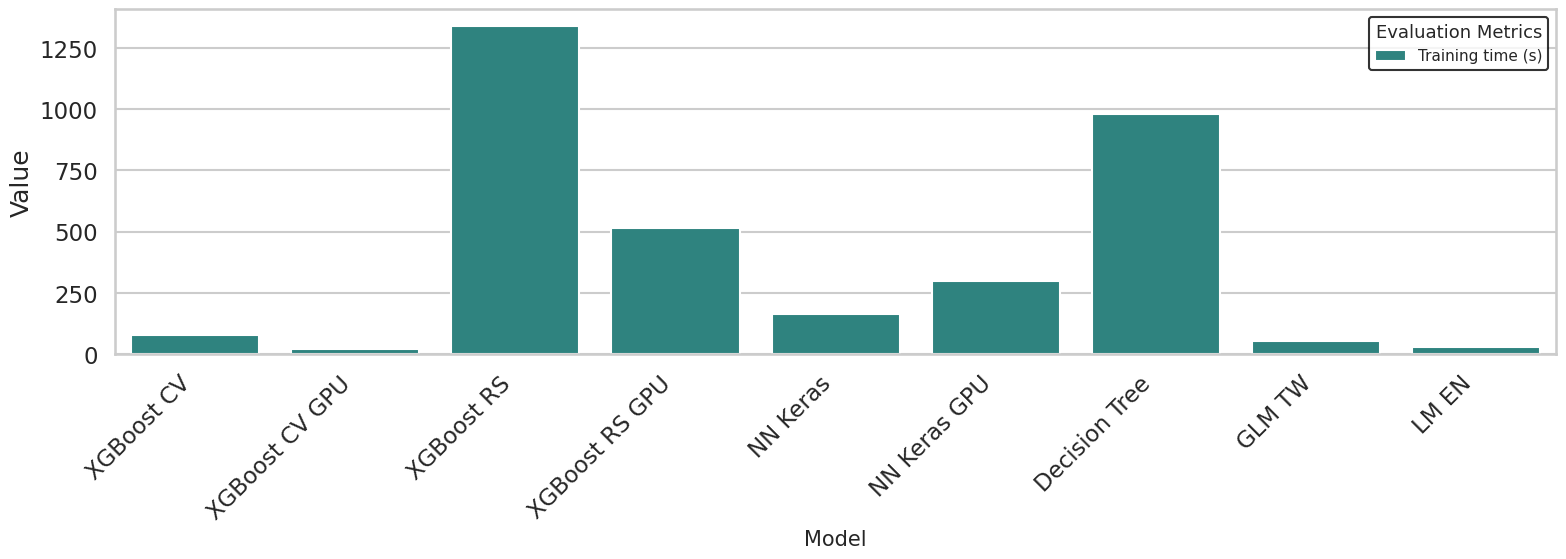

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
metrics = pd.read_csv('metrics_xgb.csv')

metrics = metrics.round(4)
metrics1 = metrics[metrics['Eval_metrics'] != 'Training time (s)']
metrics2 = metrics[metrics['Eval_metrics'] == 'Training time (s)']

metrics1m = metrics1.melt(id_vars=['Eval_metrics'], var_name='Model', value_name='Value')
metrics2m = metrics2.melt(id_vars=['Eval_metrics'], var_name='Model', value_name='Value')

r2_data = metrics1m[metrics1m['Eval_metrics'] == 'R2 Score']
data = metrics1m[metrics1m['Eval_metrics'] != 'R2 Score']
print(data)

# Set the style and context for the plot
sns.set(style="whitegrid", context="talk")

fig, ax1 = plt.subplots(figsize=(16, 6))

# Create the bar plot
bar_plot = sns.barplot(x='Model', y='Value', hue='Eval_metrics', data=metrics2m, palette='viridis')

# Add titles and labels
#ax1.set_title('Evaluation Metrics by Model', fontsize=20)
ax1.set_xlabel('Model', fontsize=15)
#ax1.set_ylabel('Value', fontsize=15)

# Customize the legend
legend = ax1.legend(title='Evaluation Metrics', title_fontsize='13', fontsize='11', loc='upper right')
legend.get_frame().set_edgecolor('black')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add gridlines for better readability
ax1.yaxis.grid(True)
ax1.xaxis.grid(False)

# Show the plot
plt.tight_layout()
plt.show()